### Introduction to Data Science - Homework 4

For demo and review purposes only!!! For more information (not sure if they'll ever offer this course again) please see the [UofU Data Science Course website at datasciencecourse.net](http://datasciencecourse.net/2016/index.html)


In this homework you will use tools from regression to study house prices in the SLC city zip code 84103. 

## Part 1: Regression of real estate data
For this problem, you will analyze SLC real estate data. The dataset contains multiple listing service (MLS) real estate transactions for houses sold in the previous year in zip code 84103 (SLC avenues neighborhod [Google Map](https://www.google.com/maps/place/Salt+Lake+City,+UT+84103/@40.8030372,-111.8957957,12z/data=!3m1!4b1!4m5!3m4!1s0x87525f672006dded:0x311e638d9a1a2de5!8m2!3d40.810506!4d-111.8449346]). We are primarily interested in regressing the SoldPrice on the house attributes (property size, house size, number of bedrooms, etc...). 


### Task 1.1 Import the data 
Use the pandas.read_csv() function to import the dataset. The data is contained in two files: 'train1.csv' and 'train2.csv'. After you import these files separately, concatenate them into one big dataframe. This pandas dataframe will be used for data exploration and linear regression. 

In [3]:
# imports and setup 
import pandas as pd
import scipy as sc

import statsmodels.formula.api as sm

import matplotlib.pyplot as plt 

plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [4]:
# Your code here
import numpy as np
import sys

# take the columns recommended / required and add DaysOnMkt, HOAFee

# orignally imported in this order, reordered to make casting easier / one line for all ints:
# 'Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 
# ... 'SoldPrice', 'Taxes', 'DaysOnMkt', 'HOAFee', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt'

train1 = pd.read_csv('train1.csv',thousands=',',usecols=['ListNo', 'Acres', 'GaragCap', 'PkgSpacs', 'LstPrice', 'SoldPrice', 'Taxes', 'DaysOnMkt', 'HOAFee', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt', 'Latitude', 'Longitude',  'Patio', 'Deck', 'PropType'])
train2 = pd.read_csv('train2.csv',thousands=',',usecols=['ListNo', 'Acres', 'GaragCap', 'PkgSpacs', 'LstPrice', 'SoldPrice', 'Taxes', 'DaysOnMkt', 'HOAFee', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt', 'Latitude', 'Longitude',  'Patio', 'Deck', 'PropType'])

print(train1.shape)
print(train2.shape)

train1ColNames = train1.columns.values
train2ColNames = train2.columns.values

if set(train1ColNames) != set(train2ColNames):
    print("The column names on the two dataframes don't match, we can't concat them")
    sys.exit()
else:
    print("We can match these dataframes because the column names match")
    homeData = pd.concat([train1,train2])
    
print(homeData.shape)

# export this for a look
homeData.to_csv('outfile-lesscols-reorder.csv')

    


(200, 18)
(148, 18)
We can match these dataframes because the column names match
(348, 18)


### Task 1.2 Clean the data 

1. There are 206 different variables associated with each of the 348 houses in this dataset. Skim them and try to get a rough understanding of what information this dataset contains. If you've never seen a real estate listing before, you might take a look at one on [this](http://www.utahrealestate.com/) website to get a better sense of the meanings of the column headers in the dataset.  

+ Only keep houses with List Price between 200,000 and 1,000,000 dollars. This is an arbitrary choice and we realize that some of you are high rollers, but for our purposes we'll consider the others as outliers. 

+ Remove columns that you don't think contribute the value of the house. This is a personal decision - what attributes of a house are important to you? You should at least keep the following variables since the questions below will use them: ['Acres', 'Deck', 'GaragCap', 'Latitude', 'Longitude', 'LstPrice', 'Patio', 'PkgSpacs', 'PropType', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt'] 

+ Check the datatypes and convert any numbers that were read as strings to numerical values. (Hint: You can use [str.replace()](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.str.replace.html) to work with strings.) If there are any categorical values you're interested in, then you should convert them to numerical values as in Lab 9. In particular, convert 'TotSqf' to an integer and add a column titled Prop_Type_num that is 
$$
\text{Prop_Type_num}_i = \begin{cases} 
0 & \text{if $i$-th listing is a condo or townhouse} \\
1 & \text{if $i$-th listing is a single family house}
\end{cases}. 
$$
+ Remove the listings with erroneous 'Longitude' (one has Longitude = 0) and 'Taxes' values (two have unreasonably large values).

In [5]:
# make a function here to feed to a lambda for making prop_type_num
def make_prop_type_num(propType):
    if (propType == "Condo") | (propType == "Townhouse"):
        return 0
    else:
        # classify any mispellings at SFH
        return 1

# not used, was going to harmonize the 0s and the .01s but used different approach    
def make_01_if_condo_townhouse(propType):
    if (propType == "Condo") | (propType == "Townhouse"):
        return .01
    
# ------- end function declarations

# NOTE generally it appears that pandas reads in and converts values to numeric with some exceptions
# but we do explicit conversions to be sure

# to get rid of listings between 200K and 1M, convert LstPrice to numeric

homeData['LstPrice'] = pd.to_numeric(homeData['LstPrice'], errors='coerce')

#step 2 -- remove "outliers"

homeData = homeData[(homeData['LstPrice'] > 200000) & (homeData['LstPrice'] < 1000000)]

print("Shape without LstPrice outliers is now ",homeData.shape)

homeData.to_csv('outfile-priceCut.csv')

# step 3 was already done earlier, when the csv files were read we used usecols= on a limited set of columns

# step 4, convert to float or int as desired and add Prop_Type_num, 0 for condo/townhouse where lot is .01, otherwise 1 for sfh

# do we need to convert? Not really but go ahead and do it just in case, clean up Nans at the end
print("BEFORE CASTING, Latitude is type: ",type(homeData['Latitude'].values[0]), " and Longitude is type: ", type(homeData['Longitude'].values[0]))

# convert lat and long to float
homeData['Latitude'] = pd.to_numeric(homeData['Latitude'], errors='coerce')
homeData['Longitude'] = pd.to_numeric(homeData['Longitude'], errors='coerce')
    
# old line before realizing these values are already int64:
# print("ListNo is type: ",type(homeData['ListNo'].values[0]), " and YearBlt is type: ", type(homeData['YearBlt'].values[0]))

# just to be sure...

# Acres, GaragCap, PkgSpacs, LstPrice, SoldPrice, Taxes, DaysOnMkt, HOAFee, TotBed to int
homeData[0:12] = homeData[0:12].astype(int, raise_on_error=False)

print("Now, after running astype on fields 0:12 the types look like this:")
print("ListNo is type: ",type(homeData['ListNo'].values[0]), " and YearBlt is type: ", type(homeData['YearBlt'].values[0]))


#also in step 4 get rid of bad Latitude values of 0
homeData = homeData[(homeData['Latitude'] > 0.0)]

print("Shape without bad lat is now ",homeData.shape)

# in theory all the condos and townhomes have either 0 or .01 for acreage, make them all .01
#not currently using this
# homeData['Acres'] = homeData['Acres'].map(make_01_if_condo_townhouse(homeData['PropType'].values))

# try based on lambda x: 'red' if x == 'Z' else 'green'
#homeData['Acres'] = homeData['PropType'].map(lambda propType: .01 if (propType == "Condo") else "original value")

# have to figure this out, how to get the "original value" from target column not in lambda

# finally check for NaN and handle
# have to use fillna differently for different columns, let's start with lot size and combine that with making Prop_Type_num

# for PropType, also handle setting Prop_Type_num
homeData['PropType'].fillna(-1)
homeData['Prop_Type_num'] = homeData['PropType'].map(make_prop_type_num)

print("Shape after adding Prop_Type_num is now ",homeData.shape)
print("The column names are now: ",homeData.columns.values)

# need to clean the rows with outsized taxes
homeData = homeData[(homeData['Taxes'] < 10000) & (homeData['Taxes'] > 100)]

# export this for a look
homeData.to_csv('outfile-mapped01s.csv')
#print out shape now
print("Shape without bad tax entries is ",homeData.shape)

# finally check/convert remaining columns to int
#  to int
homeData[17:20] = homeData[17:20].astype(int, raise_on_error=False)

# for some reason TotSqf is not being cast to int, try directly
# homeData['TotSqf'] = homeData['TotSqf'].astype(int, raise_on_error=True)
# fixed this when realized there was a comma in the numeric data that pandas choked on, put thousands= in imports

print(homeData.dtypes)

Shape without LstPrice outliers is now  (260, 18)
BEFORE CASTING, Latitude is type:  <class 'numpy.float64'>  and Longitude is type:  <class 'numpy.float64'>
Now, after running astype on fields 0:12 the types look like this:
ListNo is type:  <class 'numpy.int64'>  and YearBlt is type:  <class 'numpy.int64'>
Shape without bad lat is now  (259, 18)
Shape after adding Prop_Type_num is now  (259, 19)
The column names are now:  ['ListNo' 'Acres' 'DaysOnMkt' 'Deck' 'GaragCap' 'HOAFee' 'Latitude'
 'Longitude' 'LstPrice' 'Patio' 'PkgSpacs' 'PropType' 'SoldPrice' 'Taxes'
 'TotBed' 'TotBth' 'TotSqf' 'YearBlt' 'Prop_Type_num']
Shape without bad tax entries is  (256, 19)
ListNo             int64
Acres            float64
DaysOnMkt        float64
Deck               int64
GaragCap           int64
HOAFee           float64
Latitude         float64
Longitude        float64
LstPrice           int64
Patio              int64
PkgSpacs           int64
PropType          object
SoldPrice          int64
Taxes  

/home/jim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:48: FutureWarning: the raise_on_error=False keyword is deprecated, use errors='ignore' instead
/home/jim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:88: FutureWarning: the raise_on_error=False keyword is deprecated, use errors='ignore' instead


### Task 1.3 Exploratory data analysis 

1. Explore the dataset. Write a short description of the dataset describing the number of items, the number of variables and check to see if the values are reasonable. 

+ Make a bar chart showing the price breakdown of the different types of houses (single family, townhouse, condo). 

+ Compute the correlation matrix and make a scatter plot matrix to visualize the correlations. For the plot, only use a subset of the columns: ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']. Determine which columns have strong correlations. Write a few (complete) sentences describing your findings. 


We have a dataframe named homeData of shape:  (256, 19)
That's rows, and columns, rows are datapoints and columns are variables

The columns and types in the dataframe are:
Column  1 :  ListNo  type:  <class 'numpy.int64'>  and  0  vals outside 3 stddev
Column  2 :  Acres  type:  <class 'numpy.float64'>  and  3  vals outside 3 stddev
Column  3 :  DaysOnMkt  type:  <class 'numpy.float64'>  and  15  vals outside 3 stddev
Column  4 :  Deck  type:  <class 'numpy.int64'>  and  1  vals outside 3 stddev
Column  5 :  GaragCap  type:  <class 'numpy.int64'>  and  0  vals outside 3 stddev
Column  6 :  HOAFee  type:  <class 'numpy.float64'>  and  192  vals outside 3 stddev
Column  7 :  Latitude  type:  <class 'numpy.float64'>  and  0  vals outside 3 stddev
Column  8 :  Longitude  type:  <class 'numpy.float64'>  and  256  vals outside 3 stddev
Column  9 :  LstPrice  type:  <class 'numpy.int64'>  and  0  vals outside 3 stddev
Column  10 :  Patio  type:  <class 'numpy.int64'>  and  1  vals outside 3 

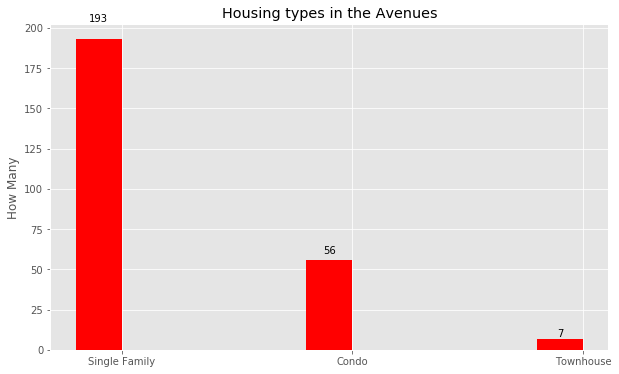

In [6]:
# autolabel function is from matplotlib demos at
# http://matplotlib.org/examples/api/barchart_demo.html

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                '%d' % int(height),
                ha='center', va='bottom')

# After cleaning we are left with a pandas dataframe called homeData with 256 rows and 19 columns. The columns are:
colNum = 0
print("We have a dataframe named homeData of shape: ",homeData.shape)
print("That's rows, and columns, rows are datapoints and columns are variables")

print("")

print("The columns and types in the dataframe are:")

# wrote my own dtypes here before I realized dtypes exists
for column in homeData:
    colNum +=1
    homeDataColumn = homeData[column]
    colType = type(homeDataColumn.values[0])
    # print(type(colType), " ", colType)
    # print("Column ", colNum, ": ",column, " type: ", colType)
    
    # now see if a column is amenable to statistical analysis for outliers
    # typesToDoStatsOn = ['numpy.int64','numpy.float64']
    # if colType in typesToDoStatsOn:  
    

    # the if above needs work, just explicitly check for int and float
    # report outlier values outside three standard deviations but not for str values
    if 'str' not in colType.__name__:
        currentColLen = len(homeData[column])
        homeDataColMean = homeData[column].mean()
        homeDataColStdDev = homeData[column].std()
        within3ColLen = len(homeData[(homeData[column] - homeDataColMean) < homeDataColMean + 3*homeDataColStdDev])
        print("Column ", colNum, ": ",column, " type: ", colType, " and ", currentColLen - within3ColLen, " vals outside 3 stddev")
    else:
        print("Column ", colNum, ": ",column, " type: ", colType)
        print( "This column is not int or float, skipping outliers check")
        
print("")
print("While some columns have data outside three standard deviations, these cases are reasonable")

# BAR CHART TIME!
# now make a bar chart per the correction showing how many condos vs. townhomes vs. sfh

# this gets us single family, condos, townhomes
counts = homeData["PropType"].value_counts()

print(counts)

countsList = counts.tolist()
print(countsList)
# setup matplotlib params
N = len(countsList)
indX = np.arange(N)
width = .2


fig, ax = plt.subplots()
rects = ax.bar(indX, countsList, width, color='r')

ax.set_ylabel('How Many')
ax.set_title('Housing types in the Avenues')
ax.set_xticks(indX + .1)
ax.set_xticklabels(('Single Family', 'Condo', 'Townhouse'))

autolabel(rects)

# this was working well but now causes intermittent errors, why?
# set the max height of y axis for more padding
#plt.ylim(0, 1.2*max(countsList))


plt.show()
    

    
    

              Acres  LstPrice  SoldPrice     Taxes    TotBed    TotBth  \
Acres      1.000000  0.716514   0.709272  0.679667  0.588792  0.504317   
LstPrice   0.716514  1.000000   0.994956  0.878015  0.649936  0.738382   
SoldPrice  0.709272  0.994956   1.000000  0.873539  0.645319  0.725797   
Taxes      0.679667  0.878015   0.873539  1.000000  0.550322  0.727814   
TotBed     0.588792  0.649936   0.645319  0.550322  1.000000  0.598941   
TotBth     0.504317  0.738382   0.725797  0.727814  0.598941  1.000000   
TotSqf     0.738134  0.865991   0.855409  0.813294  0.725074  0.788425   
YearBlt    0.110574  0.208640   0.203126  0.310047 -0.055300  0.310787   

             TotSqf   YearBlt  
Acres      0.738134  0.110574  
LstPrice   0.865991  0.208640  
SoldPrice  0.855409  0.203126  
Taxes      0.813294  0.310047  
TotBed     0.725074 -0.055300  
TotBth     0.788425  0.310787  
TotSqf     1.000000  0.150917  
YearBlt    0.150917  1.000000  


/home/jim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  


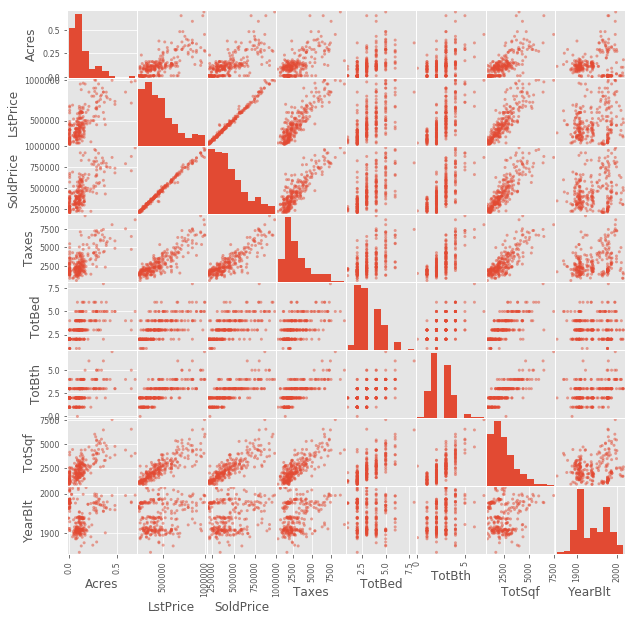

In [7]:
# now a corr matrix and scatterplot based on ['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']

homeDataCorrCols = homeData[['Acres', 'LstPrice', 'SoldPrice', 'Taxes', 'TotBed', 'TotBth', 'TotSqf', 'YearBlt']]

print(homeDataCorrCols.corr())
pd.scatter_matrix(homeDataCorrCols, figsize=(10, 10), diagonal='hist'); #; suppresses output

**Your Interpretation:**
1. Not surprisingly, List Price nearly perfectly correlates with Sold Price at 99%+. This will almost always be true, except at the point where a market drops, and housing markets drop slowly compared to more liquid markets so even then you won't see a significantly lower correlation.
2. Also not surprisingly, Sold Price correlates highly with taxes, as taxes are derived as a percent of value
3. Bedrooms drives prices with 64% correlation 
4. Bathrooms are correlated more highly with price at 73%
5. Year built is not correlated with price (20%) but this is probably because this neighborhood largely has old houses, amazingly going back to the 1850s!


NOTE: the plots with vertical or horizontal bands are discrete variables (integers) such as bedrooms and baths



### Task 1.4 Geospatial plot
Two of the variables are the latitude and longitude of each listing. Salt Lake City is on this nice east-west, north south grid, so even a simple plot of lat and long makes sense. Create a scatterplot of these two variables. Use color to indicate the price of the house. How does the price depend on the house location?

Bonus: If you can, overlay the scatterplot on a map of the city. (This is challenging, and we didn't teach you how to do it, so you might do the other parts of the assignment first.)

What can you say about the relation between the location and the house price?

In [8]:
# use here and below so DON'T MODIFY THESE
# break dependent and independent variables out to lists
listPrice = homeData['LstPrice'].tolist()
soldPrice = homeData['SoldPrice'].tolist()
# break more dependent and independent variables out to lists
totSqFt = homeData['TotSqf'].tolist()
garageCap = homeData['GaragCap'].tolist()
latTude = homeData['Latitude'].tolist()
longTude = homeData['Longitude'].tolist()

# code adapted from various sources including https://github.com/python-visualization/folium/issues/90

import folium

# make colors relate to price

# get the boundaries of histogram
colors = pd.cut(homeData['SoldPrice'], 5, right=True, include_lowest=True, labels=['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c']).tolist()

# make size of dot relate to lot size
area = pd.cut(homeData['Acres'], 5, right=True, include_lowest=True, labels=[25, 35, 45, 55, 65]).tolist()

#height and width in km, setup lat and lon
width = 1.6
height = 1

lon_0=-111.875
lat_0=40.78

#lon_0=-111.87404
#lat_0=40.7759

# method to set map boundaries for other projections:
#lon_2=-111.87404,lat_2=40.791059,lon_1=-111.87404,lat_1=40.769424)


# folium.initialize_notebook()
map_1 = folium.Map(location=[lat_0, lon_0],tiles='Stamen Terrain', zoom_start=14)

counter = 0
for lat in latTude:
    folium.CircleMarker([lat, longTude[counter]],
                    radius=area[counter],
                    popup=str(soldPrice[counter]),
                    color='black',
                    fill_color=colors[counter],
                   ).add_to(map_1)
    
    
    # map_1.simple_marker([lat, longTude[counter]])
    counter += 1

# show the map -- see notes below, no display function is needed with later versions of iPython/Jupyter
map_1

# tried to use Basemap until I realized I didn't have a way to get the ARCGis online streets working so I went with
# folium, though it's poorly documented and the examples (by admission of the developer) are often old. FYI for 
# anyone trying to use folium, v 0.1.2 is old, v 2.0 is what you want but Anaconda only seems to have 1.2. There's
# a lot of online docs about how to use a "display" function and create your own iframe HTML but now you 
# just build the map and refer to it, iPython has the display figured out automatically. Then wait. And wait. It
# takes a relatively long time to load the map. Wait for it.



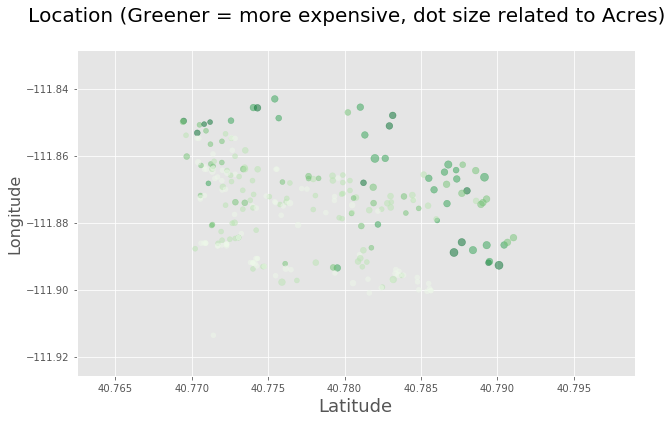

In [9]:
# now let's do a standard matplotlib map for comparison

# This is what I had before I did the folium map above ... NOTE!!!! The folium map seems to have issues with firefox,
# it takes a long time to load and intermittently gives me "script taking a long time" errors. If you don't see an
# interactive map above, you should. I included a screenshot of this section so you'd see it.

import matplotlib.pyplot as plt

# make colors relate to price

# get the boundaries of histogram
colors = pd.cut(homeData['SoldPrice'], 5, right=True, include_lowest=True, labels=['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c'])

# make size of dot relate to lot size
area = pd.cut(homeData['Acres'], 5, right=True, include_lowest=True, labels=[25, 35, 45, 55, 65])

# make colors relate to price

# get the boundaries of histogram
colors = pd.cut(homeData['SoldPrice'], 5, right=True, include_lowest=True, labels=['#edf8e9', '#bae4b3', '#74c476', '#31a354', '#006d2c'])

# make size of dot relate to lot size
area = pd.cut(homeData['Acres'], 5, right=True, include_lowest=True, labels=[25, 35, 45, 55, 65])

scfig = plt.figure()

plt.scatter(latTude, longTude, s=area, c=colors, alpha=.5)

scfig.suptitle('Location (Greener = more expensive, dot size related to Acres)', fontsize=20)
plt.xlabel('Latitude', fontsize=18)
plt.ylabel('Longitude', fontsize=16)

# having a hard time getting latlon=True, to work, might have to proportionalize the lat and lon to map grid?
# plt.scatter(homeData['Longitude'], homeData['Latitude'], s=area, c=colors, alpha=.5)

# plt.xlim = (homeData['Longitude'].min, homeData['Longitude'].max)
# plt.ylim = (homeData['Latitude'].min, homeData['Latitude'].max)

plt.show();

**Your Interpretation:** The higher you get in latitude, the more expensive the houses get. This trend has a slant along a line from the northwest to the southeast that follows the contour of the mountain. As you gain elevation, you get the houses with better views. These lots, over time, have seen more expensive houses built and start out with a lot bonus on the price.

In this plot, the colors start toward white for the least expensive houses. The greener a dot for a house it, the more expensive the house is. The size of the dots indicates the lot size, which correlates to the more expensive houses on the hillside with the best views. The eastern edge of this neighborhood begins to border on the Federal Heights neighborhood, SLC's most expensive.

### Task 1.5 Simple  Linear Regression 
Use the 'ols' function from the [statsmodels](http://www.statsmodels.org/stable/index.html) package to regress the Sold price on some of the other variables. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x, 
$$
where $x$ is one of the other variables. 

You'll find that the best predictor of sold price is the list price. Report the R-squared value for this model (SoldPrice ~ LstPrice) and give an interpretation for its meaning. Also give an interpretation of $\beta_1$ for this model. Make a plot of list price vs. sold price and overlay the prediction coming from your regression model. 

                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                 2.499e+04
Date:                Sat, 12 Aug 2017   Prob (F-statistic):          1.11e-255
Time:                        10:49:41   Log-Likelihood:                -2882.2
No. Observations:                 256   AIC:                             5768.
Df Residuals:                     254   BIC:                             5776.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.259e+04   3016.861      4.175      0.0

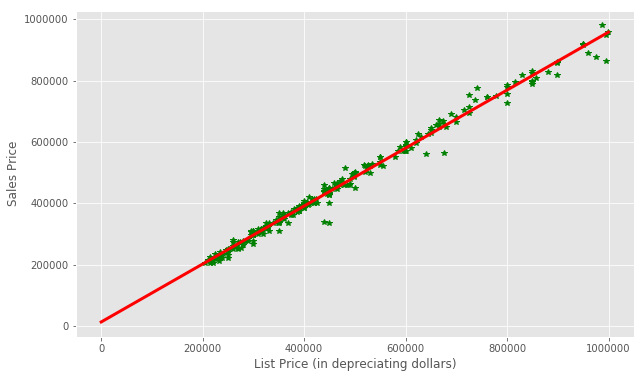

The model is:
              Sold Price = 12594.5335 + 0.9457 * Listing Price.
r-squared value = 0.9899 (measure of fit)
p-value = 0.0 (H_0: slope is zero.)
standard error = 0.006


In [10]:
# Your code here

from scipy.stats import linregress
import matplotlib as listToSoldPlot

model = sm.ols(formula="SoldPrice ~ LstPrice", data=homeData)
model_result = model.fit()
print(model_result.summary());

# make listPrice and soldPrice earlier

plt.plot(listPrice,soldPrice,'g*')

# adapted from http://localhost:8843/notebooks/05-linear-regression.ipynb cell 
# and http://localhost:8869/notebooks/06-regression-2.ipynb
lrListToSold = linregress(x=listPrice, y=soldPrice)
print(lrListToSold)

x = sc.linspace(0,max(listPrice),1000)

# the stats version of y = mx + b
plt.plot(x,lrListToSold.intercept + lrListToSold.slope*x,'r',linewidth=3)
plt.xlabel('List Price (in depreciating dollars)')
plt.ylabel('Sales Price')
plt.show()

print('The model is:') 


print('              Sold Price = ' + str(round(lrListToSold.intercept,4)) + ' + ' + str(round(lrListToSold.slope,4)) + ' * Listing Price.')
print("r-squared value = " + str(round(lrListToSold.rvalue**2,4)) + " (measure of fit)")
print("p-value = " + str(round(lrListToSold.pvalue,4)) + " (H_0: slope is zero.)")
print("standard error = " + str(round(lrListToSold.stderr,4)))

**Your Interpretation:** The R-Squared value is .99 which inidicates a near perfect correlation between listing price and sales price. Comments above discuss why in nearly all markets this is such a direct correlation. I will add here, it would be interesting to track initial list price vs. final list price. In areas like San Francisco, you can see bidding wars where people pay $100,000 or more than the list price. Houses are intentionally underpriced because of this.

While we do see some houses selling for more than the listing prices, there are a few notable cases where the selling prices fell short of the listing price. Real estate agents tell to oversell homeowners on how much their house will bring in, we might be seeing the work of a small number of unethical agents here.

In more stable housing markets like SLC, and in times like today where we are beginning to see price reductions in a saturated market, the list price may come down over time before an offer is received. This is another external factor that leads the final list price to so closely reflect the sold price. It's likely as we see the housing market cooling off and potentially going into another 2005-like situation that the initial listing prices would be significantly higher. The descent of listing price through the life of the listing could be used to predict direction of prices.

A more accurate measure would be days on market, which we'll use in the multi-variable model.

### Task 1.6 Multilinear Regression 
Develop a multilinear regression model for house prices in this neighborhood. Do not include the list price in your model and, for now, ignore the categorical variable Prop_Type. Your model should be of the form:
$$
\text{Sold Price} = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \cdots +  \beta_n x_n, 
$$
where $x_i$ are predictive variables. Which variables are the best predictors for the Sold Price? 

Specific questions:
1. Often the price per square foot for a house is advertised. Is this what the coefficient for TotSqf is measuring? Provide an interpretation for the coefficient for TotSqf.  
+ Estimate the value that each Garage space adds to a house. 
+ Does latitude or longitude have an impact on house price? Explain. 
+ If we wanted to start a 'house flipping' company, we'd have to be able to do a better job of predicting the sold price than the list price does. How does your model compare? 

In [11]:
# refers to totSqFt, garageCap, latTude, longTude created above

model = sm.ols(formula="SoldPrice ~ TotSqf + GaragCap + Latitude + Longitude", data=homeData)
model_result = model.fit()
print(model_result.params)
print(model_result.summary())

Intercept    1.951483e+08
TotSqf       9.781776e+01
GaragCap     4.176976e+04
Latitude     3.044570e+06
Longitude    2.852656e+06
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.794
Model:                            OLS   Adj. R-squared:                  0.791
Method:                 Least Squares   F-statistic:                     241.9
Date:                Sat, 12 Aug 2017   Prob (F-statistic):           7.77e-85
Time:                        10:49:41   Log-Likelihood:                -3268.7
No. Observations:                 256   AIC:                             6547.
Df Residuals:                     251   BIC:                             6565.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.02

**Your Interpretation:** 
1. They advertise cost per sq. ft. in commercial rentals but that's always understating the price once you account for CAM fees, so even that if not a great predictor of actual cost. But in residential real estate I don't think I've ever seen that as part of an MLS listing. Here TotSqf is not exactly precise, as it tends to measure not actual usable square footage, but instead it uses the outside building measurements. You can't live in the walls, stairwells or utility closets of TotSqf overstates actual living space. On the flip side, TotSqf doesn't include unfinished areas like garages or basements so there can be some potential to finish a basement and add a bedroom or two, something that will greatly affect a house price.

2. I think I am having a problem with the way lat and long are represented that makes the output come in scientific notation, need some guidance on what I am doing wrong here. 

3. As noted previously, the more north you get and the more east you get (in this neighborhood) the better view you potentially have and the nicer, bigger houses get built on bigger lots. So price goes up as you go north and / or east, generally speaking. Having said that, real estate is "location, location, location!" so two houses next to each other can have different prices and feels based on corner lots, traffic, nearby commercial properties or parks.

4. The adjusted R-squared is less than .80. From task 1.5, the SoldPrice = C + A*ListPrice model keeps the adjusted R-squared at .99, so this multivariate model is not doing a very good job.

                 ListNo     Acres  DaysOnMkt      Deck  GaragCap    HOAFee  \
ListNo         1.000000 -0.040005  -0.632543  0.005498 -0.086585 -0.088448   
Acres         -0.040005  1.000000   0.018557  0.164762  0.447622 -0.148562   
DaysOnMkt     -0.632543  0.018557   1.000000 -0.011368  0.163153  0.194736   
Deck           0.005498  0.164762  -0.011368  1.000000  0.078693 -0.057099   
GaragCap      -0.086585  0.447622   0.163153  0.078693  1.000000  0.192276   
HOAFee        -0.088448 -0.148562   0.194736 -0.057099  0.192276  1.000000   
Latitude       0.022259  0.567971  -0.067906  0.183555  0.323161  0.124816   
Longitude     -0.046931  0.237989   0.004225  0.021729  0.080759 -0.113659   
LstPrice      -0.028848  0.716514   0.123127  0.163363  0.636560  0.257272   
Patio          0.045037  0.004686  -0.053990  0.753512 -0.048767 -0.279382   
PkgSpacs      -0.004046  0.179438   0.074097  0.029056 -0.025381 -0.000469   
SoldPrice     -0.011397  0.709272   0.094670  0.159171  0.626434

/home/jim/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  after removing the cwd from sys.path.


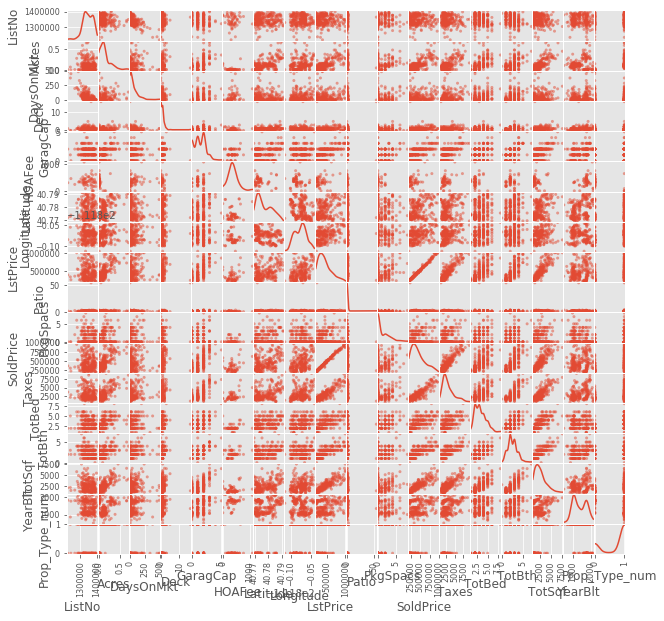

In [12]:
# doing a correlation matrix and scatter matrix for the extra info

print(homeData.corr())
pd.scatter_matrix(homeData, figsize=(10, 10), diagonal='kde');

### Task 1.7 Incorporating a categorical variable

Above, we considered houses, townhouses, and condos together, but here we'll distinguish between them. Consider the two regression models: 
$$
\text{SoldPrice} = \beta_0 + \beta_1 \text{Prop_Type_num}
$$
and 
$$
\text{SoldPrice} = \beta_0  + \beta_1 \text{Prop_Type_num} + \beta_2 \text{TotSqf}
$$
From the first model, it would appear that Property type is significant in predicting the sold price. On the other hand, the second model indicates that when you take into account total square footage, property type is no longer predictive. Explain this. (Hint: there is a confounder lurking here.) Make a scatterplot of TotSqf vs. SoldPrice where the house types are colored differently to illustrate your explanation. 

Looking at linear regression with single variable...
The model is:   y   = beta_0 + beta_1 * x_1
             SoldPrice = 324957.1429 + 168076.225 * Prop_Type_num.
r-squared value = 0.1498 (measure of fit)
p-value = 0.0 (H_0: slope is zero.)
standard error = 25129.061


Now looking at multiple regression with TotSqf variable and Prop_Type_num...
Intercept        118461.333712
Prop_Type_num     11634.366891
TotSqf              130.585975
dtype: float64
                            OLS Regression Results                            
Dep. Variable:              SoldPrice   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.730
Method:                 Least Squares   F-statistic:                     346.1
Date:                Sat, 12 Aug 2017   Prob (F-statistic):           3.94e-73
Time:                        10:50:29   Log-Likelihood:                -3302.2
No. Observations:                 256   AIC:                          

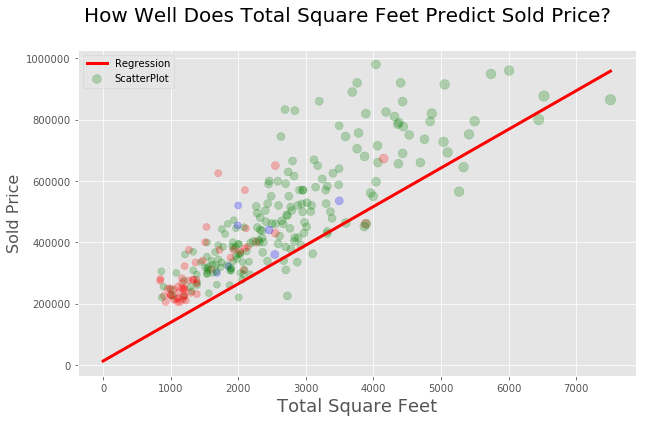

In [13]:
def setColorByPropType(propType):
    if propType == "Condo":
        return 'red'
    elif propType == "Townhouse":
        return 'blue'
    else:
        return 'green'
    
# end function declarations

print("Looking at linear regression with single variable...")

propTypeNum = homeData['Prop_Type_num']

lrSoldVsPTn = linregress(x=propTypeNum, y=soldPrice)

print('The model is:   y   = beta_0 + beta_1 * x_1') 
print('             SoldPrice = ' + str(round(lrSoldVsPTn.intercept,4)) + ' + ' + str(round(lrSoldVsPTn.slope,4)) + ' * Prop_Type_num.')
print("r-squared value = " + str(round(lrSoldVsPTn.rvalue**2,4)) + " (measure of fit)")
print("p-value = " + str(round(lrSoldVsPTn.pvalue,4)) + " (H_0: slope is zero.)")
print("standard error = " + str(round(lrSoldVsPTn.stderr,4)))
print("\n")

print("Now looking at multiple regression with TotSqf variable and Prop_Type_num...")

model17 = sm.ols(formula="SoldPrice ~ Prop_Type_num + TotSqf", data=homeData)
model_result = model17.fit()
print(model_result.params)
print(model_result.summary())


# scatterplot

import matplotlib.pyplot as lastPlot

# background image, skip for now because the images takes over the x and y limits, solve that
#from scipy.misc import imread
# background images of clouds
#im = imread("clouds.jpg")
#lastPlot.imshow(im,zorder=-10000)


# make a series colors that assigns colors by property type, white for condo, blue for townhouse, green for sfh
colors = homeData['PropType'].map(setColorByPropType)

# make size of dot relate to lot size
area = pd.cut(homeData['TotSqf'], 5, right=True, include_lowest=True, labels=[50,65,80,95,110])

theText = 'Figure 1.7 Sold Price regression against Total Square Feet by Property Type'

lastFig = lastPlot.figure()

lastFig.suptitle('How Well Does Total Square Feet Predict Sold Price?', fontsize=20)
# lastFig.text(20, 20, theText)
lastPlot.xlabel('Total Square Feet', fontsize=18)
lastPlot.ylabel('Sold Price', fontsize=16)

# this legend is not quite what I want, I want each color dot for each prop type
# look at this SO post to fix this: http://stackoverflow.com/questions/21654635/scatter-plots-in-pandas-pyplot-how-to-plot-by-category
scatterLegend = lastPlot.scatter(totSqFt, soldPrice, s=area, c=colors, alpha=.25, zorder=1, label='ScatterPlot')


theRangeLeft = min(totSqFt)
theRangeRight = max(totSqFt)

print("The range is ", theRangeLeft, " to ", theRangeRight)

lastPlot.xlim = (theRangeLeft, theRangeRight)
lastPlot.ylim = (min(soldPrice), max(soldPrice))

# now show a regression line
lrSqFtToSold = linregress(x=totSqFt, y=soldPrice)
print(lrListToSold)

xLast = sc.linspace(0,max(totSqFt),1000)

# the stats version of y = mx + b
regressionLine, = lastPlot.plot(xLast,lrListToSold.intercept + lrListToSold.slope*x,'r',linewidth=3, label='Regression')

# legend examples:
#plt.plot([1,2,3], label='Line 2')
#line_down, = plt.plot([3,2,1], label='Line 1')


lastPlot.legend(handles=[scatterLegend,regressionLine])

lastPlot.legend(loc='upper left')

lastPlot.show()








**Your Interpretation:** NOTE: Somehow I have my regression line overlaid improperly, I think I need to scale prop type num to match square feet but not sure, looking for some guidance on this. 

If I had to hazard a guess on the confounder, having run out of time to do actual analysis, I would say that Prop_Type (and therefore PropType_num) is not independent from TotSqf. As far as a confounder it would likely be number of bedrooms and bathrooms.
